In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


#  Problema a resolver

**Objetivo:**  
Predecir las posiciones futuras (coordenadas `x`, `y`) de los jugadores en el campo durante una jugada de pase en la NFL, utilizando información de seguimiento (*tracking data*) antes del lanzamiento del balón.  

Este problema busca modelar el movimiento de los jugadores para mejorar la comprensión táctica del juego y apoyar estrategias de predicción espacial.

---

##  Entradas (Features)

Las variables de entrada corresponden a información de jugadas, jugadores y su dinámica en el campo antes del lanzamiento del balón:

| **Variable** | **Descripción** |
|:--------------|:----------------|
| `game_id` | Identificador único del partido (numérico). |
| `play_id` | Identificador de la jugada (numérico, no único entre juegos). |
| `player_to_predict` | Indica si se evaluará la predicción de este jugador (`True`/`False`). |
| `nfl_id` | Identificador único del jugador (numérico). |
| `frame_id` | Número de cuadro (*frame*) dentro de la jugada, comienza en 1 para cada `game_id` y `play_id` (numérico). |
| `play_direction` | Dirección en la que avanza la ofensiva (`left` o `right`). |
| `absolute_yardline_number` | Distancia desde la zona de anotación del equipo en posesión (numérico). |
| `player_name` | Nombre del jugador (texto). |
| `player_height` | Altura del jugador en pies-pulgadas. |
| `player_weight` | Peso del jugador en libras (lbs). |
| `player_birth_date` | Fecha de nacimiento del jugador (`yyyy-mm-dd`). |
| `player_position` | Posición o rol típico del jugador en el campo (e.g., QB, WR, DB). |
| `player_side` | Equipo al que pertenece el jugador (`Offense` o `Defense`). |
| `player_role` | Rol específico en la jugada (`Passer`, `Targeted Receiver`, `Defensive Coverage`, `Other Route Runner`). |
| `x` | Posición del jugador a lo largo del eje longitudinal del campo (0–120 yardas). |
| `y` | Posición del jugador a lo largo del eje transversal del campo (0–53.3 yardas). |
| `s` | Velocidad instantánea del jugador (yardas/segundo). |
| `a` | Aceleración instantánea (yardas/segundo²). |
| `o` | Orientación corporal del jugador (en grados). |
| `dir` | Dirección del movimiento del jugador (en grados). |
| `num_frames_output` | Cantidad de cuadros a predecir para ese jugador (numérico). |
| `ball_land_x` | Posición en el eje longitudinal donde aterriza el balón (yardas). |
| `ball_land_y` | Posición en el eje transversal donde aterriza el balón (yardas). |

---

##  Salidas (Targets)

El conjunto de salida contiene las posiciones **predichas** de los jugadores **después** del lanzamiento del balón.

| **Variable** | **Descripción** |
|:--------------|:----------------|
| `game_id` | Identificador del partido (numérico). |
| `play_id` | Identificador de la jugada (numérico). |
| `nfl_id` | Identificador único del jugador (numérico). |
| `frame_id` | Número de *frame* en la secuencia posterior al lanzamiento (numérico). |
| `x` | **Posición predicha** del jugador a lo largo del eje longitudinal del campo (objetivo a predecir). |
| `y` | **Posición predicha** del jugador a lo largo del eje transversal del campo (objetivo a predecir). |



In [3]:
def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)
    
    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")
    
    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")
    
    return train_df

train_df = load_training_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440


In [4]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


### **Analisis Exploratorio**

In [5]:
train_df.info() #revisar cantidad de datos, tipos de datos, campos vacios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

In [6]:
import pandas as pd

# Identificar columnas categóricas (tipo object)
categorical_cols = train_df.select_dtypes(include='object').columns

# Mostrar el conteo de valores únicos de cada columna categórica
for col in categorical_cols:
    print(f"\n{'='*80}")
    print(f"Columna: {col}")
    print(f"{'='*80}")
    display(train_df[col].value_counts().to_frame(name='Conteo'))



Columna: play_direction


,Conteo
play_direction,
right,2459074
left,2421505



Columna: player_name


,Conteo
player_name,
Cameron Sutton,13641
Jared Goff,13517
Dak Prescott,13400
Darious Williams,13343
Patrick Mahomes,13299
...,...
Tremon Smith,17
Tae Davis,15
Thomas Incoom,15



Columna: player_height


,Conteo
player_height,
6-1,909987
6-0,810480
6-2,709743
5-11,552849
6-3,532059
6-4,376636
5-10,362030
6-5,220944
5-9,203225



Columna: player_birth_date


,Conteo
player_birth_date,
1993-01-22,24787
1996-05-21,23168
1999-10-06,23146
1996-05-16,21936
1999-04-19,21231
...,...
1991-05-23,18
2000-03-06,18
1996-07-20,17



Columna: player_position


,Conteo
player_position,
WR,1063660
CB,1056888
FS,476865
TE,417146
QB,401007
SS,392421
RB,314918
ILB,295593
OLB,207429



Columna: player_side


,Conteo
player_side,
Defense,2662657
Offense,2217922



Columna: player_role


,Conteo
player_role,
Defensive Coverage,2662657
Other Route Runner,1424243
Targeted Receiver,396914
Passer,396765


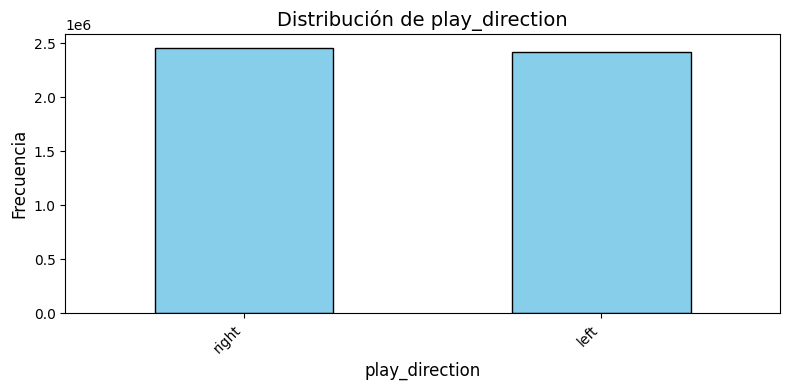

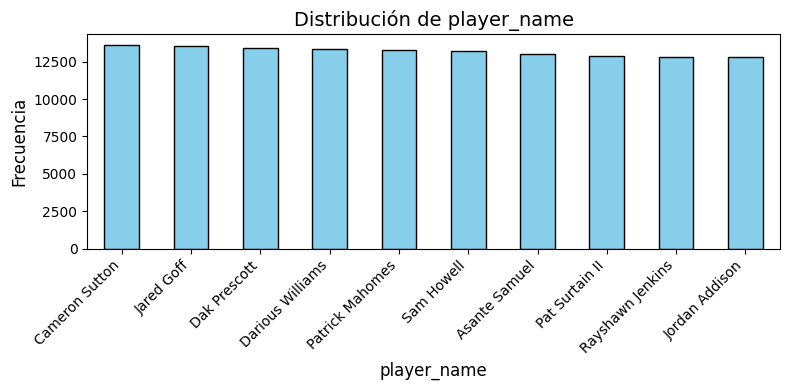

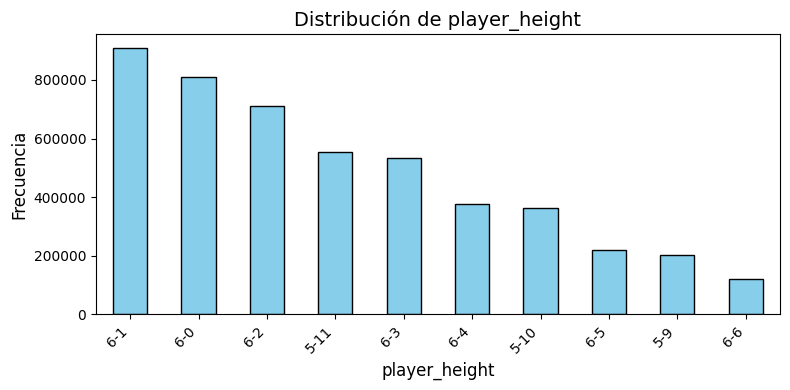

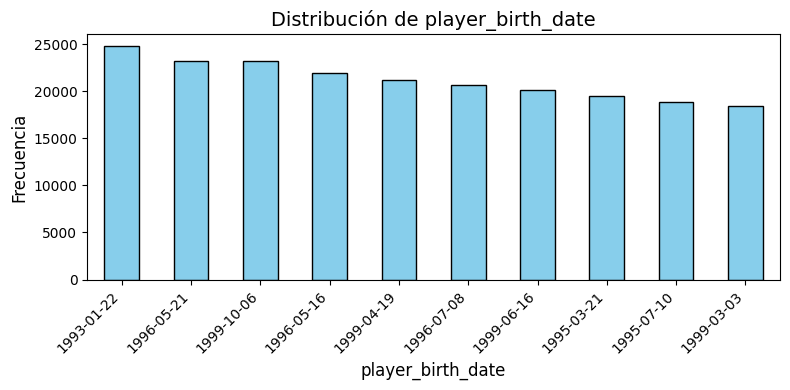

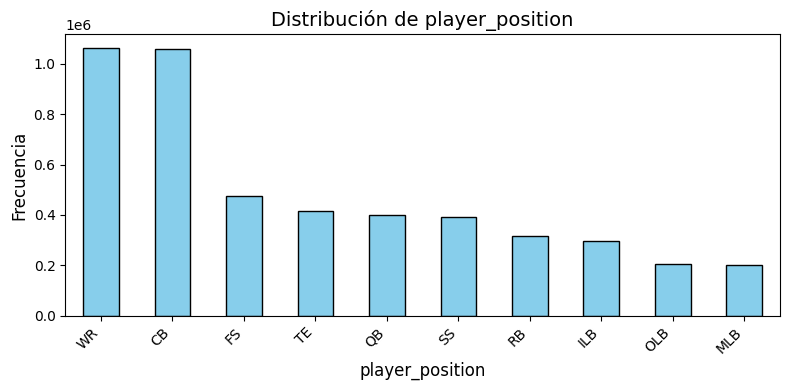

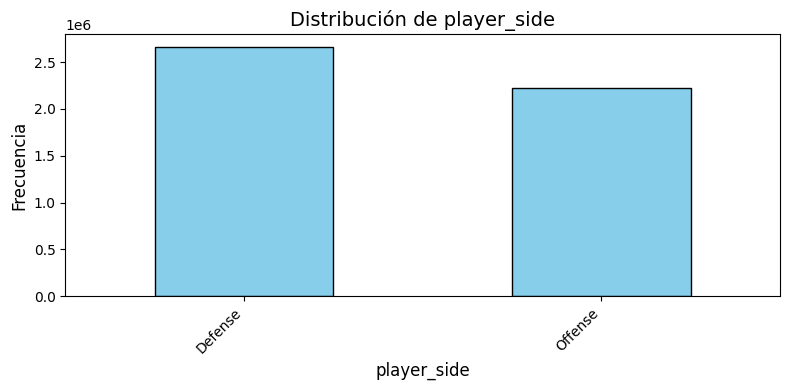

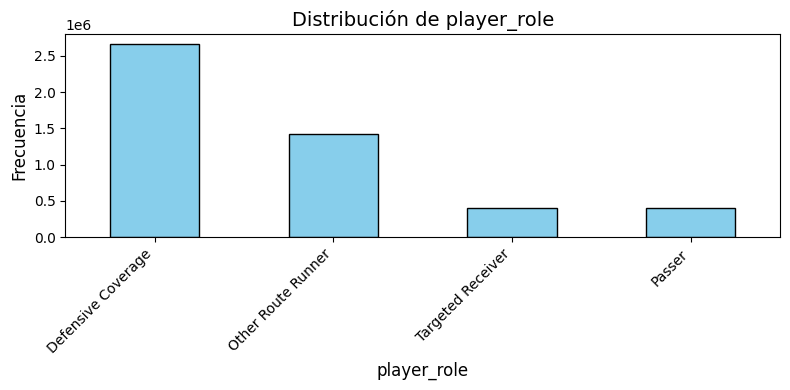

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Identificar las columnas categóricas
categorical_cols = train_df.select_dtypes(include='object').columns

# Crear una gráfica de barras para cada variable categórica
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    # Mostrar solo las 10 categorías más frecuentes (para evitar saturar gráficos)
    train_df[col].value_counts().head(10).plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'Distribución de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [8]:
# Mostrar estadísticas básicas de las variables numéricas
train_df.describe()


,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


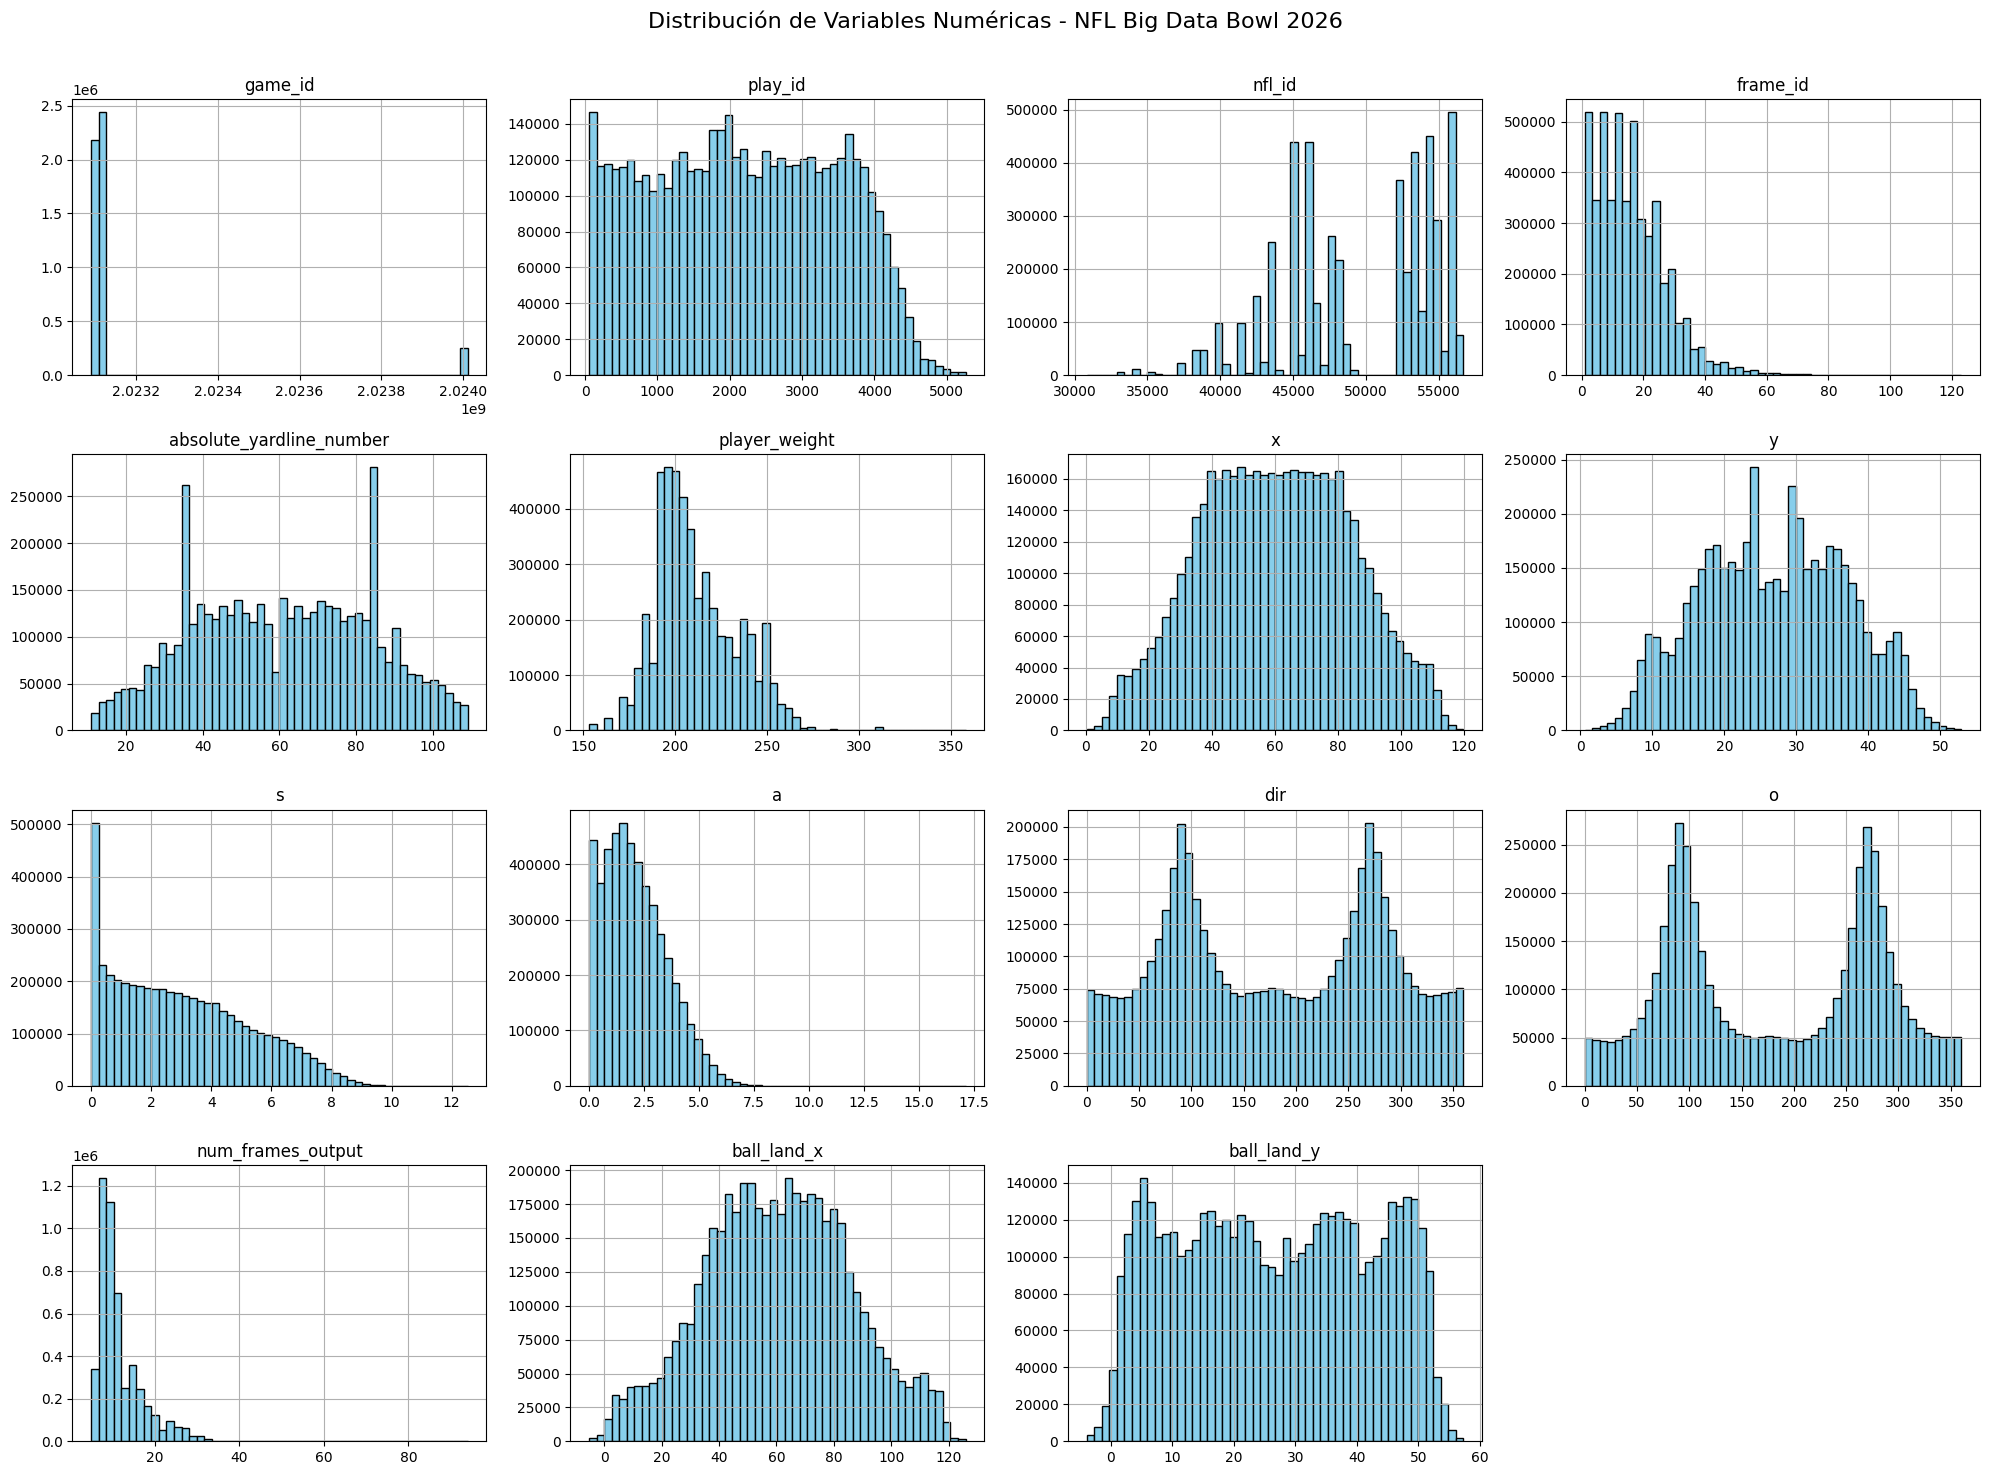

In [9]:
import matplotlib.pyplot as plt

# Crear histogramas de todas las variables numéricas del dataset NFL
train_df.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')

plt.suptitle("Distribución de Variables Numéricas - NFL Big Data Bowl 2026", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajustar para no tapar el título
plt.show()


### **Preparacion de Datos**

In [10]:
# ============================================================
#  PREPARACIÓN DE VARIABLES CATEGÓRICAS - NFL Big Data Bowl 2026
# ============================================================

import pandas as pd
from datetime import datetime

# Copia de seguridad del dataset original
df = train_df.copy()

# Variables categóricas del dataset
categoricas = [
    'play_direction', 'player_name', 'player_height',
    'player_birth_date', 'player_position', 'player_side', 'player_role'
]

# ------------------------------------------------------------
# Convertir altura "6-2" a pulgadas totales (numérico)
# ------------------------------------------------------------
df['player_height_inches'] = df['player_height'].apply(
    lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]) 
    if isinstance(x, str) and '-' in x else None
)

# ------------------------------------------------------------
# Convertir fecha de nacimiento a edad actual (numérico)
# ------------------------------------------------------------
current_year = datetime.now().year
df['player_age'] = df['player_birth_date'].apply(
    lambda d: current_year - int(d.split('-')[0]) 
    if isinstance(d, str) and '-' in d else None
)

# ------------------------------------------------------------
# Codificar nombre del jugador como número
# ------------------------------------------------------------
df['player_name_code'] = df['player_name'].astype('category').cat.codes

# ------------------------------------------------------------
# Aplicar One-Hot Encoding a variables categóricas puras
# ------------------------------------------------------------
categoricas_puras = ['play_direction', 'player_position', 'player_side', 'player_role']
df_encoded = pd.get_dummies(df, columns=categoricas_puras, drop_first=False)

# ------------------------------------------------------------
# Eliminar columnas originales redundantes (object)
# ------------------------------------------------------------
cols_a_eliminar = ['player_name', 'player_height', 'player_birth_date']
df_clean = df_encoded.drop(columns=cols_a_eliminar)

# ------------------------------------------------------------
# Verificar estructura final del DataFrame limpio
# ------------------------------------------------------------
print("\n Dataset transformado y limpio correctamente. Vista general:\n")
df_clean.info()

# ------------------------------------------------------------
# Confirmar que no quedan columnas tipo 'object'
# ------------------------------------------------------------
print("\n Tipos de datos restantes:")
print(df_clean.dtypes.value_counts())

# ------------------------------------------------------------
# Vista previa final del dataset limpio
# ------------------------------------------------------------
df_clean.head()



 Dataset transformado y limpio correctamente. Vista general:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 46 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   game_id                         int64  
 1   play_id                         int64  
 2   player_to_predict               bool   
 3   nfl_id                          int64  
 4   frame_id                        int64  
 5   absolute_yardline_number        int64  
 6   player_weight                   int64  
 7   x                               float64
 8   y                               float64
 9   s                               float64
 10  a                               float64
 11  dir                             float64
 12  o                               float64
 13  num_frames_output               int64  
 14  ball_land_x                     float64
 15  ball_land_y                     float64
 16  player_he

,game_id,play_id,player_to_predict,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,...,player_position_SS,player_position_T,player_position_TE,player_position_WR,player_side_Defense,player_side_Offense,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
0,2023090700,101,False,54527,1,42,210,52.33,36.94,0.09,...,False,False,False,False,True,False,True,False,False,False
1,2023090700,101,False,54527,2,42,210,52.33,36.94,0.04,...,False,False,False,False,True,False,True,False,False,False
2,2023090700,101,False,54527,3,42,210,52.33,36.93,0.12,...,False,False,False,False,True,False,True,False,False,False
3,2023090700,101,False,54527,4,42,210,52.35,36.92,0.23,...,False,False,False,False,True,False,True,False,False,False
4,2023090700,101,False,54527,5,42,210,52.37,36.90,0.35,...,False,False,False,False,True,False,True,False,False,False


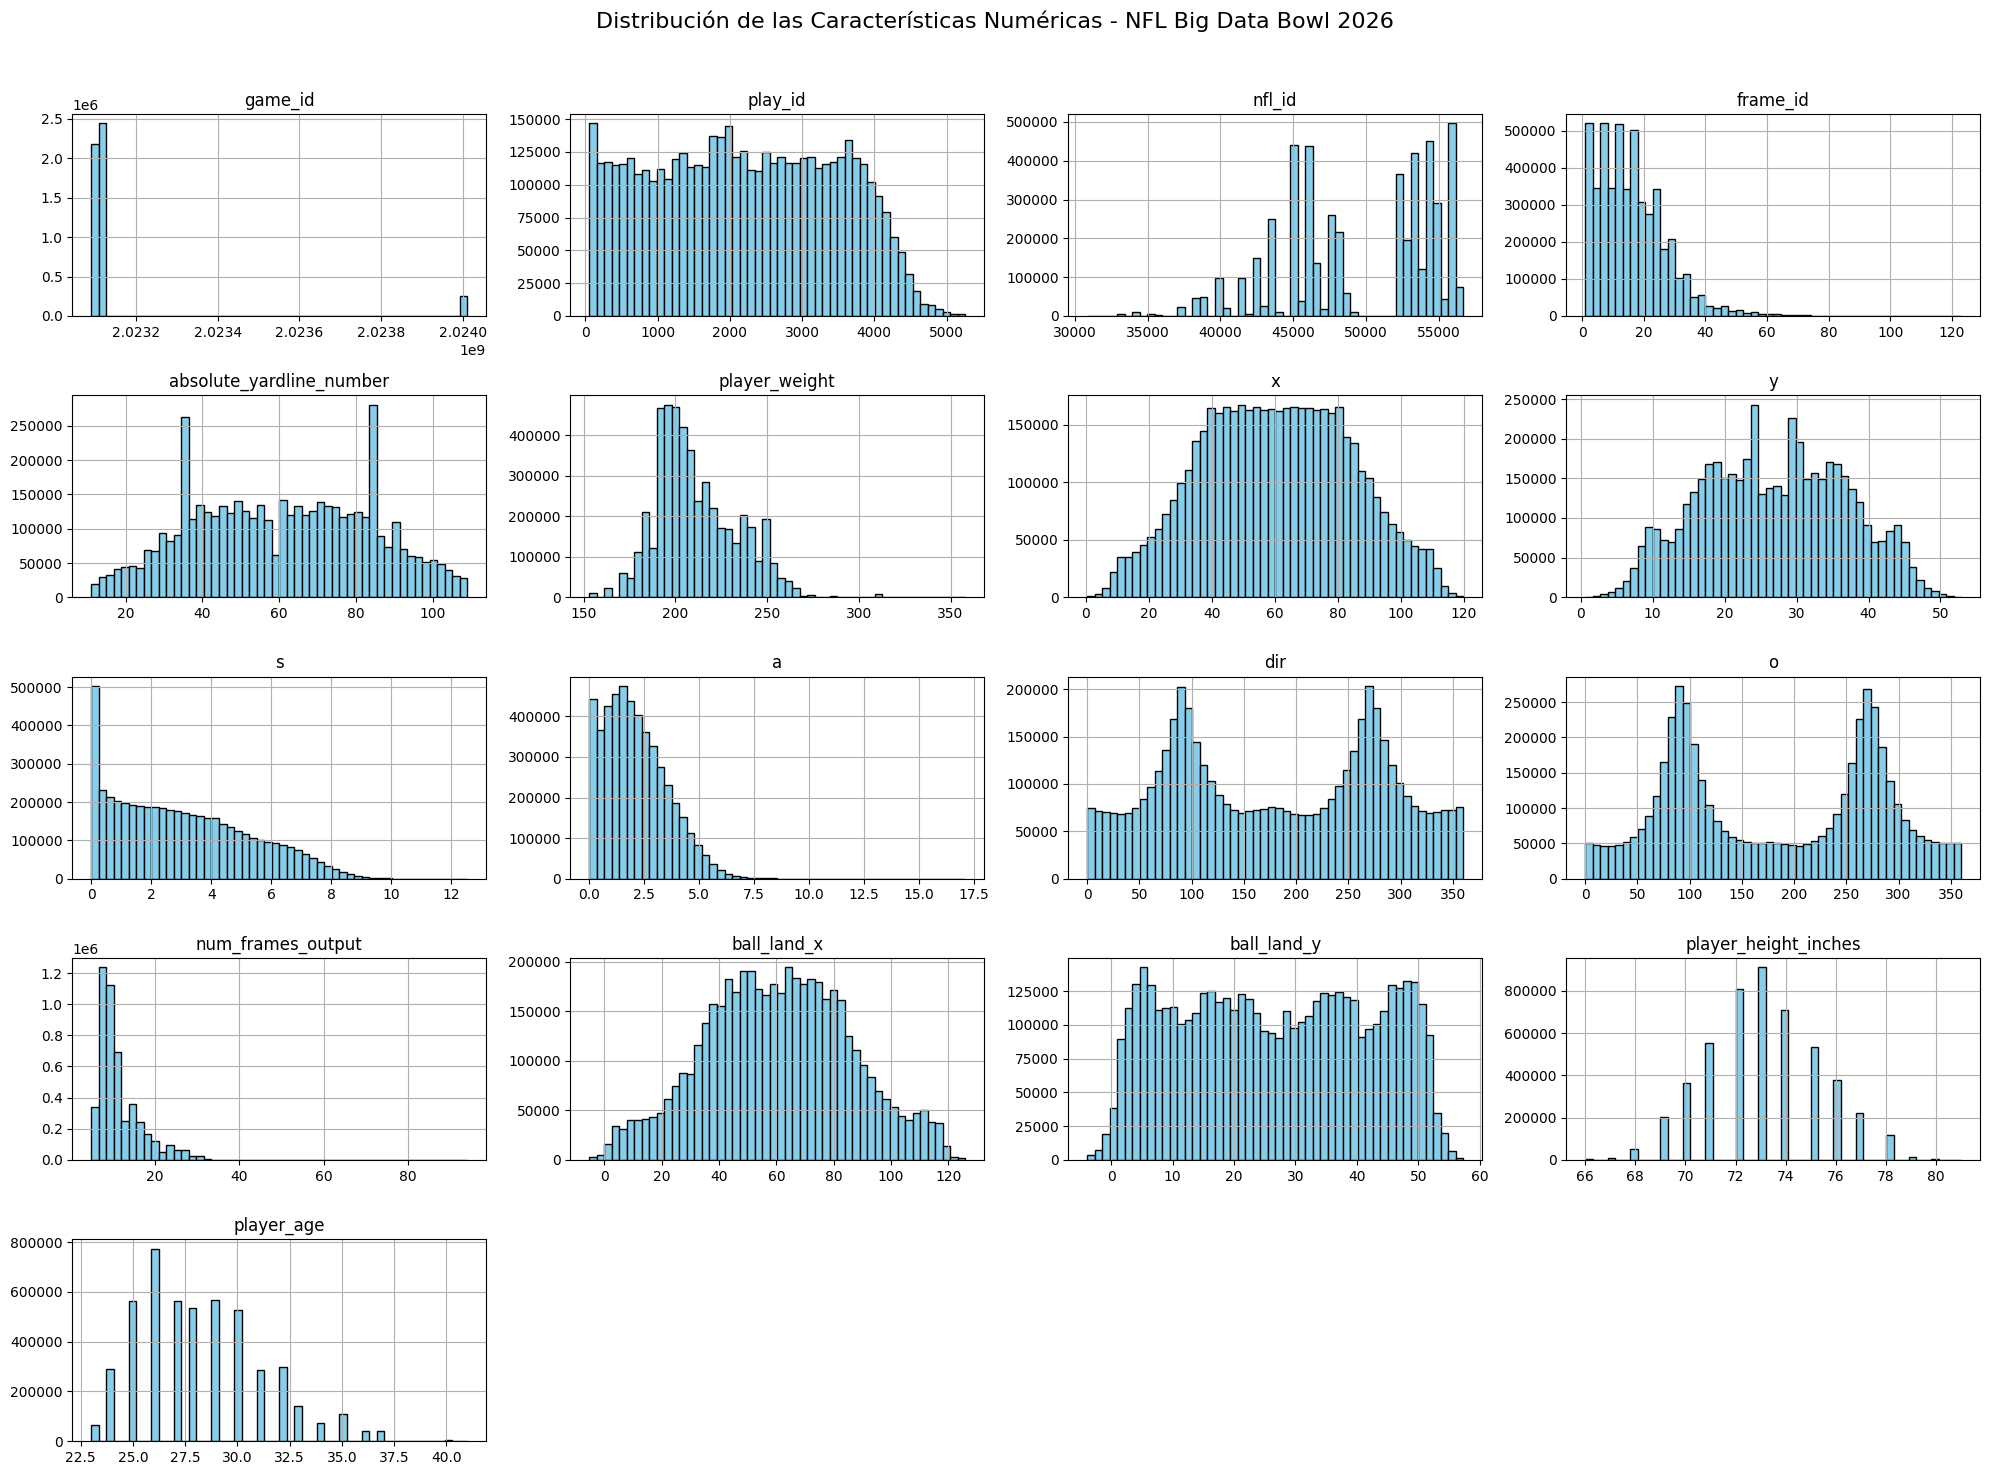

In [11]:
# ============================================================
#  HISTOGRAMAS DE TODAS LAS VARIABLES NUMÉRICAS - NFL DATASET
# ============================================================

import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas del dataset limpio
nfl_numeric = df_clean.select_dtypes(include=['int64', 'float64'])

# Generar histogramas
nfl_numeric.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')

plt.suptitle("Distribución de las Características Numéricas - NFL Big Data Bowl 2026", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # deja espacio para el título
plt.show()


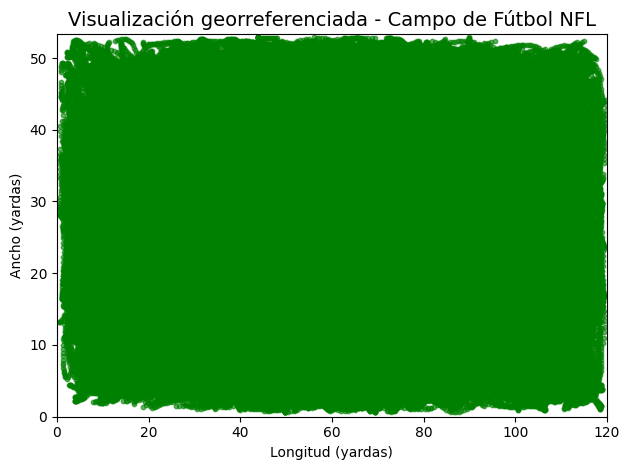

In [12]:
# ============================================================
#  VISUALIZACIÓN SIMPLE DEL CAMPO DE FÚTBOL - NFL DATASET
# ============================================================

import matplotlib.pyplot as plt

# Crear la gráfica de dispersión (como ejemplo georreferenciado)
train_df.plot(kind="scatter", x="x", y="y", alpha=0.6, s=10, color="green")

# Ajustar estilo y guardar
plt.title("Visualización georreferenciada - Campo de Fútbol NFL", fontsize=14)
plt.xlabel("Longitud (yardas)")
plt.ylabel("Ancho (yardas)")

plt.xlim(0, 120)   # largo del campo
plt.ylim(0, 53.3)  # ancho del campo

plt.tight_layout()
plt.savefig('/kaggle/working/nfl_field_scatter.pdf', format='pdf', dpi=300)
plt.show()


In [13]:
# ============================================================
#  MATRIZ DE CORRELACIÓN - NFL Big Data Bowl 2026
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# Crear una copia del dataset limpio (ya codificado)
nfl_corr = df_clean.copy()

# Asegurarse de eliminar cualquier columna no numérica (por precaución)
nfl_corr = nfl_corr.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
corr_matrix = nfl_corr.corr()

# Mostrar la matriz con formato visual (colores)
corr_matrix.style.background_gradient(cmap='coolwarm')


,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,player_height_inches,player_age
game_id,1.000000,-0.046649,0.018240,-0.005799,0.006925,-0.005850,0.004195,0.002696,-0.003865,-0.000483,0.002208,0.002352,0.003425,-0.000923,0.007239,0.002222,-0.014961
play_id,-0.046649,1.000000,0.016456,0.005741,-0.008377,-0.027185,-0.008586,-0.000180,-0.003735,-0.023165,0.000818,-0.000943,0.045453,-0.008406,-0.001256,-0.015770,-0.013200
nfl_id,0.018240,0.016456,1.000000,0.000521,-0.000295,-0.147903,0.000225,0.000361,0.035575,0.023728,-0.004477,-0.005935,0.000720,0.000538,0.000932,0.020471,-0.930573
frame_id,-0.005799,0.005741,0.000521,1.000000,0.005030,0.004452,0.006850,0.002267,0.556111,0.210484,-0.002570,-0.002717,0.080511,0.006660,0.003080,-0.003382,0.000743
absolute_yardline_number,0.006925,-0.008377,-0.000295,0.005030,1.000000,0.003593,0.937889,-0.004579,-0.000619,0.001649,0.092848,-0.004493,-0.011060,0.841294,-0.000779,0.001108,0.001086
player_weight,-0.005850,-0.027185,-0.147903,0.004452,0.003593,1.000000,0.003312,0.002333,-0.080487,0.014764,0.002948,0.008709,-0.013794,0.003559,0.003507,0.654504,0.163320
x,0.004195,-0.008586,0.000225,0.006850,0.937889,0.003312,1.000000,-0.005442,-0.002098,0.001613,-0.066573,0.131395,-0.012528,0.859600,-0.009878,0.001023,0.000552
y,0.002696,-0.000180,0.000361,0.002267,-0.004579,0.002333,-0.005442,1.000000,-0.002318,-0.001657,-0.000736,0.006594,0.000495,-0.004685,0.050480,0.002592,0.002221
s,-0.003865,-0.003735,0.035575,0.556111,-0.000619,-0.080487,-0.002098,-0.002318,1.000000,0.212926,0.002747,-0.018597,0.053797,-0.002347,-0.001241,-0.005145,-0.048362
a,-0.000483,-0.023165,0.023728,0.210484,0.001649,0.014764,0.001613,-0.001657,0.212926,1.000000,-0.002907,-0.007024,0.007182,0.001751,0.000826,0.056490,-0.028840


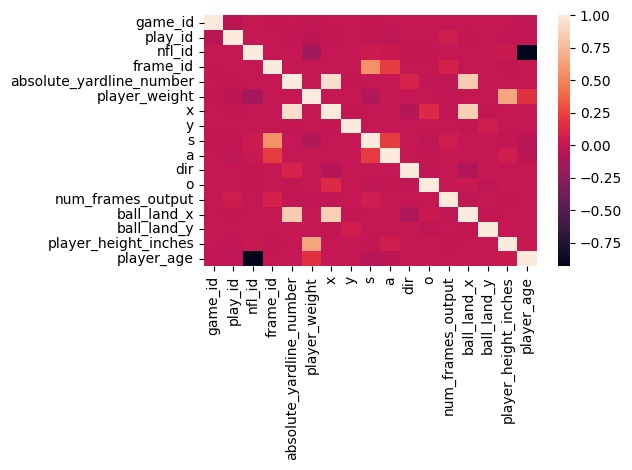

In [14]:
### ============================================================
#  MATRIZ DE CORRELACIÓN (VISUALIZACIÓN) - NFL Big Data Bowl 2026
# ============================================================

import seaborn as sns  # librería útil para graficar mapas de calor
import matplotlib.pyplot as plt

sns.heatmap(
    corr_matrix,
    xticklabels=corr_matrix.columns.values,
    yticklabels=corr_matrix.columns.values
)

plt.tight_layout()
plt.savefig('/kaggle/working/nfl_corr_matrix.pdf', format='pdf', dpi=300)
plt.show()


In [15]:
# ============================================================
#  CORRELACIÓN CON VARIABLES OBJETIVO (x, y) - NFL Big Data Bowl 2026
# ============================================================

# Correlación de todas las variables con la coordenada 'x'
print("🔹 Correlaciones con la variable objetivo 'x':\n")
print(corr_matrix["x"].sort_values(ascending=False))

print("\n🔹 Correlaciones con la variable objetivo 'y':\n")
print(corr_matrix["y"].sort_values(ascending=False))


🔹 Correlaciones con la variable objetivo 'x':

x                           1.000000
absolute_yardline_number    0.937889
ball_land_x                 0.859600
o                           0.131395
frame_id                    0.006850
game_id                     0.004195
player_weight               0.003312
a                           0.001613
player_height_inches        0.001023
player_age                  0.000552
nfl_id                      0.000225
s                          -0.002098
y                          -0.005442
play_id                    -0.008586
ball_land_y                -0.009878
num_frames_output          -0.012528
dir                        -0.066573
Name: x, dtype: float64

🔹 Correlaciones con la variable objetivo 'y':

y                           1.000000
ball_land_y                 0.050480
o                           0.006594
game_id                     0.002696
player_height_inches        0.002592
player_weight               0.002333
frame_id                    0.

In [ ]:
# ============================================================
#  MATRIZ DE DISPERSIÓN - VARIABLES CLAVE NFL
# ============================================================

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Variables más relevantes del tracking NFL
attributes = ["x", "y", "s", "a", "o", "dir"]

scatter_matrix(df_clean[attributes], figsize=(12, 8), alpha=0.6, diagonal='hist')

plt.suptitle("Matriz de Dispersión - Posición, Velocidad y Dirección NFL", fontsize=14)
plt.tight_layout()
plt.savefig('/kaggle/working/scatter_matrix_nfl_core.pdf', format='pdf', dpi=300)
plt.show()
